# Projet : Analyse des Avis et Alertes ANSSI avec en option Enrichissement des CVE 

Réalisé par:

- Dame DIOP 

- Adrien CALTAGIRONE

- Cantin BRUNO


## Introduction
duction
La cybersécurité est essentielle pour protéger les entreprises contre les attaques informatiques. En France, l'ANSSI aide à identifier et corriger les vulnérabilités en publiant des bulletins de sécurité. Ces bulletins, qui comprennent des avis et des alertes sur des vulnérabilités critiques, sont moins automatisés et flexibles que ceux de leur homologue américain, le NIST, ce qui complique l'analyse et l'exploitation des données pour les utilisateurs. Cela souligne le besoin de développer des outils pour mieux gérer et analyser ces informations.

## Objectifs

- Extraire les données des flux RSS des avis et alertes ANSSI.  
- Identifier les CVE mentionnées dans les bulletins.  
- Enrichir les CVE avec des informations complémentaires via des API externes.  
- Consolider les données dans un format exploitable (DataFrame pandas).  
- Analyser et visualiser le DataFrame obtenu (vulnérabilités critiques, scores...)  
- Générer des alertes personnalisées pour les produits affectés et envoyer des notifications par email.

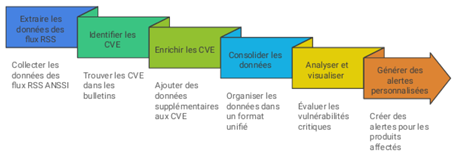

## Déroulements

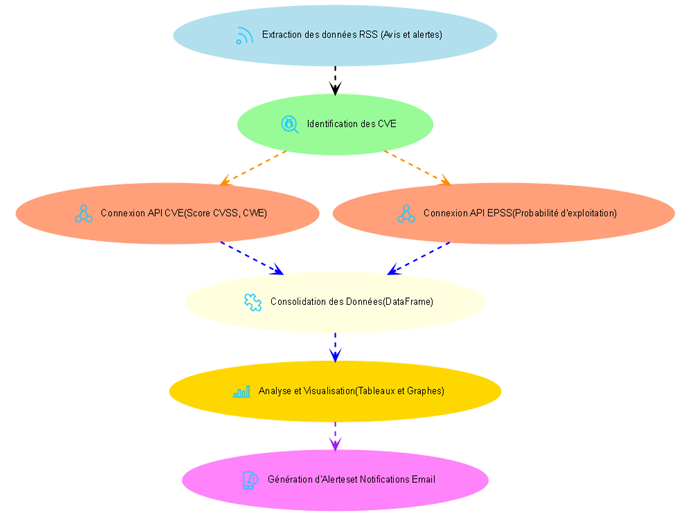

## Les imports nécéssaires au projet

In [46]:
import feedparser

import numpy as n
import pandas as pd
import matplotlib.pyplot as pl
import requests
import re
import json

## Étape 1 : Extraction des Flux RSS  
Les flux RSS des avis et alertes de l'ANSSI sont extraits grâce à la bibliothèque `feedparser` ou une autre de votre choix. 
L'extraction permet d'obtenir les informations suivantes : Titre, Description, Date de publication et Lien vers le bulletin 
détaillé. 

In [51]:
# URL du flux RSS de l'ANSSI
url = "https://www.cert.ssi.gouv.fr/avis/feed"

# Extraction du flux RSS
rss_feed = feedparser.parse(url)
# Liste pour stocker les données
data = []

# Parcourir les entrées du flux
for entry in rss_feed.entries:
    titre = entry.title
    description = entry.description
    lien = entry.link
    date = entry.published

    # Ajouter les informations sous forme de dictionnaire
    data.append({"Titre": titre, "Description": description, "Lien": lien, "Date": date})

# Convertir les données en DataFrame pour un affichage structuré
df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
df


,Titre,Description,Lien,Date
0,Multiples vulnérabilités dans les produits Mozilla (08 janvier 2025),"De multiples vulnérabilités ont été découvertes dans les produits Mozilla. Certaines d'entre elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance, une élévation de privilèges et un déni de service à distance.",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0009/,"Wed, 08 Jan 2025 08:09:37 +0000"
1,Vulnérabilité dans VMware Aria automation et Cloud Fondation (08 janvier 2025),Une vulnérabilité a été découverte dans VMware Aria automation et Cloud Fondation. Elle permet à un attaquant de provoquer un contournement de la politique de sécurité.,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0011/,"Wed, 08 Jan 2025 08:25:49 +0000"
2,Vulnérabilité dans Google Chrome (08 janvier 2025),Une vulnérabilité a été découverte dans Google Chrome. Elle permet à un attaquant de provoquer un problème de sécurité non spécifié par l'éditeur.,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0012/,"Wed, 08 Jan 2025 08:29:05 +0000"
3,Multiples vulnérabilités dans les produits SonicWall (08 janvier 2025),"De multiples vulnérabilités ont été découvertes dans les produits SonicWall. Certaines d'entre elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance, une élévation de privilèges et un déni de service à distance.",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0013/,"Wed, 08 Jan 2025 08:31:07 +0000"
4,Multiples vulnérabilités dans les produits Ivanti (09 janvier 2025),De multiples vulnérabilités ont été découvertes dans les produits Ivanti. Elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance et une élévation de privilèges.,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0014/,"Thu, 09 Jan 2025 07:42:19 +0000"
5,Multiples vulnérabilités dans GitLab (09 janvier 2025),"De multiples vulnérabilités ont été découvertes dans GitLab. Certaines d'entre elles permettent à un attaquant de provoquer un déni de service à distance, une atteinte à la confidentialité des données et un contournement de la politique de sécurité.",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0015/,"Thu, 09 Jan 2025 09:13:32 +0000"
6,Multiples vulnérabilités dans les produits Palo Alto Networks (09 janvier 2025),"De multiples vulnérabilités ont été découvertes dans les produits Palo Alto Networks. Certaines d'entre elles permettent à un attaquant de provoquer une atteinte à la confidentialité des données, une atteinte à l'intégrité des données et un problème de sécurité non spécifié par l'éditeur.",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0016/,"Thu, 09 Jan 2025 09:21:11 +0000"
7,Vulnérabilité dans les produits HPE Aruba Networking (09 janvier 2025),Une vulnérabilité a été découverte dans les produits HPE Aruba Networking. Elle permet à un attaquant de provoquer une atteinte à la confidentialité des données et un contournement de la politique de sécurité.,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0017/,"Thu, 09 Jan 2025 09:32:48 +0000"
8,Multiples vulnérabilités dans les produits Juniper Networks (09 janvier 2025),"De multiples vulnérabilités ont été découvertes dans les produits Juniper Networks. Certaines d'entre elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance, un déni de service à distance et une atteinte à la confidentialité des données.",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0018/,"Thu, 09 Jan 2025 09:47:38 +0000"
9,Multiples vulnérabilités dans Mozilla Thunderbird (09 janvier 2025),"De multiples vulnérabilités ont été découvertes dans Mozilla Thunderbird. Certaines d'entre elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance, une élévation de privilèges et un déni de service à distance.",https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0019/,"Thu, 09 Jan 2025 12:26:44 +0000"


## Étape 2 : Extraction des CVE 

Une fois les liens des bulletins obtenus, nous accédons aux fichiers JSON pour identifier les CVE mentionnées.  
Vous remarquez que le lien du JSON s’obtient en ajoutant tout simplement "JSON" au line de l’alerte ou de l’avis de l’ANSSI.  


In [34]:
def get_cve_id(url: str) -> list:
    if not "www.cert.ssi.gouv.fr" in url:
        return []

    # Requête    
    response = requests.get(url)
    data = response.json()

    # Extraction des CVE reference dans la clé cves du dict data
    # ref_cves=json.dumps(data["cves"], indent=4)
    # print(ref_cves)

    ref_cves = data["cves"]
    cve_pattern = r"CVE-\d{4}-\d{4,7}"
    cve_ids = []

    for ref_cve in ref_cves:
        cve_id = ref_cve.get("name")

        # Check le format de l'ID
        if not re.match(cve_pattern, cve_id):
            print("Format ID CVE incorrect")

        cve_ids.append(cve_id)
        print("Référence CVE trouvée : ", cve_id)
    return cve_ids

url = "https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0009/json/"

cve_ids = get_cve_id(url)
print(cve_ids)

Référence CVE trouvée :  CVE-2025-0242
Référence CVE trouvée :  CVE-2025-0241
Référence CVE trouvée :  CVE-2025-0244
Référence CVE trouvée :  CVE-2025-0237
Référence CVE trouvée :  CVE-2025-0247
Référence CVE trouvée :  CVE-2025-0239
Référence CVE trouvée :  CVE-2025-0243
Référence CVE trouvée :  CVE-2025-0246
Référence CVE trouvée :  CVE-2025-0238
Référence CVE trouvée :  CVE-2025-0240
Référence CVE trouvée :  CVE-2025-0245
['CVE-2025-0242', 'CVE-2025-0241', 'CVE-2025-0244', 'CVE-2025-0237', 'CVE-2025-0247', 'CVE-2025-0239', 'CVE-2025-0243', 'CVE-2025-0246', 'CVE-2025-0238', 'CVE-2025-0240', 'CVE-2025-0245']


## Étape 3 : Enrichissement des CVE  
Les identifiants CVE extraits sont enrichis grâce à des API externes :  
• API CVE de MITRE : Permet d'obtenir le score CVSS et le type CWE associé.  
• API EPSS de FIRST : Permet d'obtenir la probabilité d'exploitation de la vulnérabilité.  

Le score CVSS (Common Vulnerability Scoring System) :  
Une note de 0 à 10 qui indique la gravité d'une vulnérabilité.  
• 0-3 : Faible  
• 4-6 : Moyenne  
• 7-8 : Élevée  
• 9-10 : Critique  

Le type de vulnérabilité CWE (Common Weakness Enumeration) :  
• Il décrit la nature de la faille (par exemple : erreur d'accès mémoire, injection SQL, etc.).  

Le score EPSS (Exploit Prediction Scoring System) :  
• Il estime la probabilité qu'une vulnérabilité soit exploitée par des attaquants.  
• Une valeur entre 0 et 1 (plus le score est proche de 1, plus la faille est dangereuse).  

In [53]:
import requests

def print_api_response(cve_id):
    cve_url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
    response = requests.get(cve_url)
    data = response.json()
    print("Réponse complète de l'API pour", cve_id, ":\n", data)

# Test avec un exemple
cve_id = "CVE-2023-46805"  # Remplacez par un CVE valide pour votre cas
print_api_response(cve_id)



Réponse complète de l'API pour CVE-2023-46805 :
 {'dataType': 'CVE_RECORD', 'dataVersion': '5.1', 'cveMetadata': {'cveId': 'CVE-2023-46805', 'assignerOrgId': '36234546-b8fa-4601-9d6f-f4e334aa8ea1', 'state': 'PUBLISHED', 'assignerShortName': 'hackerone', 'dateReserved': '2023-10-27T01:00:13.399Z', 'datePublished': '2024-01-12T17:02:16.452Z', 'dateUpdated': '2024-08-02T20:53:21.908Z'}, 'containers': {'cna': {'descriptions': [{'lang': 'en', 'value': 'An authentication bypass vulnerability in the web component of Ivanti ICS 9.x, 22.x and Ivanti Policy Secure allows a remote attacker to access restricted resources by bypassing control checks.'}], 'affected': [{'defaultStatus': 'unaffected', 'vendor': 'Ivanti', 'product': 'ICS', 'versions': [{'version': '9.1R18', 'status': 'affected', 'lessThanOrEqual': '9.1R18', 'versionType': 'semver'}, {'version': '22.6R2', 'status': 'affected', 'lessThanOrEqual': '22.6R2', 'versionType': 'semver'}]}, {'defaultStatus': 'unaffected', 'vendor': 'Ivanti', 'p

In [55]:
def enrichir(cve_ids):
    for cve_id in cve_ids:
        print(f"\nTraitement de {cve_id}:")

        # Connexion à l'API CVE de MITRE pour obtenir les détails
        cve_url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        response = requests.get(cve_url)
        data = response.json()

        # Extraction des informations à partir du container 'cna'
        cna_data = data.get("containers", {}).get("cna", {})
        descriptions = cna_data.get("descriptions", [])
        description = descriptions[0].get("value") if descriptions else "Non disponible"

        # Tentative d'extraction du score CVSS
        metrics = cna_data.get("metrics", [])
        cvss_info = metrics[0].get("cvssV3_0", {}) if metrics else {}
        cvss_score = cvss_info.get("baseScore", "Non disponible")
        cvss_severity = cvss_info.get("baseSeverity", "Non disponible")

        # Tentative d'extraction du type CWE
        cwe = "Non disponible"
        problem_types = data.get("problemtype", {}).get("problemtype_data", [])
        if problem_types:
            cwe_list = problem_types[0].get("description", [])
            if cwe_list:
                cwe = cwe_list[0].get("value", "Non disponible")

        # Affichage des résultats de l'API CVE
        print(f"CVE : {cve_id}")
        print(f"Description : {description}")
        print(f"Score CVSS : {cvss_score} ({cvss_severity})")
        print(f"Type CWE : {cwe}")

        # Connexion à l’API EPSS pour récupérer la probabilité d'exploitation
        epss_url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        epss_response = requests.get(epss_url)
        epss_data = epss_response.json()

        # Extraction du score EPSS
        epss_data_list = epss_data.get("data", [])
        epss_score = epss_data_list[0].get("epss") if epss_data_list else "Non disponible"
        print(f"Score EPSS : {epss_score}")

enrichir(cve_ids)




Traitement de CVE-2025-0242:
CVE : CVE-2025-0242
Description : Memory safety bugs present in Firefox 133, Thunderbird 133, Firefox ESR 115.18, Firefox ESR 128.5, Thunderbird 115.18, and Thunderbird 128.5. Some of these bugs showed evidence of memory corruption and we presume that with enough effort some of these could have been exploited to run arbitrary code. This vulnerability affects Firefox < 134, Firefox ESR < 128.6, Firefox ESR < 115.19, Thunderbird < 134, and Thunderbird < 128.6.
Score CVSS : Non disponible (Non disponible)
Type CWE : Non disponible
Score EPSS : 0.000440000

Traitement de CVE-2025-0241:
CVE : CVE-2025-0241
Description : When segmenting specially crafted text, segmentation would corrupt memory leading to a potentially exploitable crash. This vulnerability affects Firefox < 134, Firefox ESR < 128.6, Thunderbird < 134, and Thunderbird < 128.6.
Score CVSS : Non disponible (Non disponible)
Type CWE : Non disponible
Score EPSS : 0.000450000

Traitement de CVE-2025-02